Ordinary Differential Equations: Conversion Reaction
============================

This example provides a model for the interconversion of two species 
($X_1$ and $X_2$) following first-order mass action kinetics with the 
parameters $\Theta_1$ and $\Theta_2$ respectively:


$$
    X_1 \rightarrow X_2, \quad\text{rate} = \Theta_1 \cdot [X_1]
$$

$$
    X_2 \rightarrow X_1, \quad\text{rate} = \Theta_2 \cdot [X_2]
$$

Measurement of $[X_2]$ is provided as $Y = [X_2]$.

We will show how to estimate $\Theta_1$ and $\Theta_2$ using pyABC.

In [1]:
%matplotlib inline

import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
import scipy as sp
import time

db_path = ("sqlite://")

In [2]:
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                               theta2=pyabc.RV("uniform", 0, 1))
parameter_prior.get_parameter_names()

eps_list=[5, 3, 2, 1, 0.75, 0.5, 0.33, 0.25]
#eps = pyabc.ListEpsilon(eps_list)
eps=pyabc.MedianEpsilon(500, median_multiplier=0.8)
pop_size = 500
noise_factor=0.025
iters=100
min_eps=0.2

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{\text{true}}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 

ODE model
---------

$$
    \begin{align*}
    \frac{dX_1}{dt} &= -\Theta_1 \cdot X_1 + \Theta_2 \cdot X_2\\
    \frac{dX_2}{dt} &= \Theta_1 \cdot X_1 - \Theta_2 \cdot X_2
    \end{align*}
$$

Define the true parameters

and the measurement data

In [3]:
theta1_true, theta2_true = np.exp([-2.5, -2])
measurement_data = np.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])

as well as the time points at which to evaluate

and the initial conditions for $X_1$ and $X_2$

In [4]:
measurement_times = np.arange(len(measurement_data))        
init = np.array([1, 0])

Define the ODE model

In [5]:
def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2



def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],pars["theta2"]))
    noise = noise_factor*np.random.normal(0,1,len(sol[:,1]))
    return {"X_2": sol[:,1]+noise}

Integration of the ODE model for the true parameter values

In [6]:
true_trajectory = model({"theta1": theta1_true,
                         "theta2": theta2_true})["X_2"]

Let's visualize the results

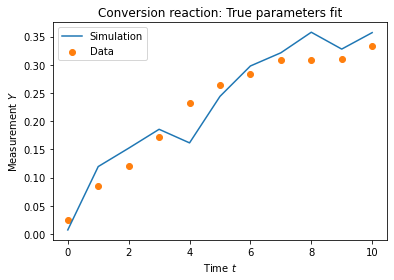

In [7]:
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In [8]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [9]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, 
                                                       look_ahead = True, 
                                                       look_ahead_delay_evaluation=True)
abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        transitions=pyabc.LocalTransition(k_fraction=.3),
        eps=eps)

histories=[]
runtimes=np.zeros(iters)
for i in range(iters):
    starttime=time.time()
    abc.new(db_path, {"X_2": measurement_data});
    endtime=time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    histories.append(h)
    runtimes[i]=endtime-starttime

INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:25:11.306893, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.880175641335174.
INFO:ABC:Acceptance rate: 500 / 1706 = 2.9308e-01, ESS=4.7365e+02.
INFO:ABC:t: 2, eps: 0.8499185546462853.
INFO:ABC:Acceptance rate: 500 / 1853 = 2.6983e-01, ESS=4.6928e+02.
INFO:ABC:t: 3, eps: 0.5215528861889831.
INFO:ABC:Acceptance rate: 500 / 2850 = 1.7544e-01, ESS=4.6953e+02.
INFO:ABC:t: 4, eps: 0.34891214669140486.
INFO:ABC:Acceptance rate: 500 / 2907 = 1.7200e-01, ESS=4.7920e+02.
INFO:ABC:t: 5, eps: 0.2340324461606582.
INFO:ABC:Acceptance rate: 500 / 5074 = 9.8542e-02, ESS=4.5659e+02.
INFO:ABC:t: 6, eps: 0.1674612409328681.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 20919 = 2.3902e-02, ESS=3.8723e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:25:11.306893, end_time=2020-12-08 2

INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7619949156278016.
INFO:ABC:Acceptance rate: 500 / 1646 = 3.0377e-01, ESS=4.7101e+02.
INFO:ABC:t: 2, eps: 0.8556198794737956.
INFO:ABC:Acceptance rate: 500 / 1943 = 2.5733e-01, ESS=4.7775e+02.
INFO:ABC:t: 3, eps: 0.5196051437282961.
INFO:ABC:Acceptance rate: 500 / 3072 = 1.6276e-01, ESS=4.5456e+02.
INFO:ABC:t: 4, eps: 0.34074934821126523.
INFO:ABC:Acceptance rate: 500 / 3087 = 1.6197e-01, ESS=4.8066e+02.
INFO:ABC:t: 5, eps: 0.23149939513039208.
INFO:ABC:Acceptance rate: 500 / 4805 = 1.0406e-01, ESS=4.3999e+02.
INFO:ABC:t: 6, eps: 0.16707457333264675.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 22271 = 2.2451e-02, ESS=3.4404e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:27:54.145141, end_time=2020-12-08 23:28:11.647298)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:28:11.6566

INFO:ABC:t: 1, eps: 1.8551724699386094.
INFO:ABC:Acceptance rate: 500 / 1809 = 2.7640e-01, ESS=4.8874e+02.
INFO:ABC:t: 2, eps: 0.76923578877935.
INFO:ABC:Acceptance rate: 500 / 2137 = 2.3397e-01, ESS=4.8745e+02.
INFO:ABC:t: 3, eps: 0.4817650214350879.
INFO:ABC:Acceptance rate: 500 / 3251 = 1.5380e-01, ESS=4.5512e+02.
INFO:ABC:t: 4, eps: 0.3242467248315723.
INFO:ABC:Acceptance rate: 500 / 3115 = 1.6051e-01, ESS=4.7247e+02.
INFO:ABC:t: 5, eps: 0.2240395013796015.
INFO:ABC:Acceptance rate: 500 / 6137 = 8.1473e-02, ESS=4.6578e+02.
INFO:ABC:t: 6, eps: 0.16178344093738223.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 33439 = 1.4953e-02, ESS=4.0737e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:30:23.359221, end_time=2020-12-08 23:30:45.325659)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:30:45.335854, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, 

INFO:ABC:t: 2, eps: 0.770321376526372.
INFO:ABC:Acceptance rate: 500 / 2112 = 2.3674e-01, ESS=4.6623e+02.
INFO:ABC:t: 3, eps: 0.4917208585732142.
INFO:ABC:Acceptance rate: 500 / 3053 = 1.6377e-01, ESS=4.4612e+02.
INFO:ABC:t: 4, eps: 0.33028419128546294.
INFO:ABC:Acceptance rate: 500 / 3205 = 1.5601e-01, ESS=4.7921e+02.
INFO:ABC:t: 5, eps: 0.22852705235924084.
INFO:ABC:Acceptance rate: 500 / 5147 = 9.7144e-02, ESS=3.8219e+02.
INFO:ABC:t: 6, eps: 0.16294798752482934.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 30234 = 1.6538e-02, ESS=4.1853e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:33:02.011828, end_time=2020-12-08 23:33:22.749325)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:33:22.758582, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.785989454474442.
INFO:ABC:Acceptance rate: 500 / 1584 = 3.1566e-01

INFO:ABC:t: 3, eps: 0.4918096604510416.
INFO:ABC:Acceptance rate: 500 / 3224 = 1.5509e-01, ESS=4.5706e+02.
INFO:ABC:t: 4, eps: 0.33082454518798116.
INFO:ABC:Acceptance rate: 500 / 3304 = 1.5133e-01, ESS=4.8507e+02.
INFO:ABC:t: 5, eps: 0.22456100610261856.
INFO:ABC:Acceptance rate: 500 / 5229 = 9.5621e-02, ESS=4.4786e+02.
INFO:ABC:t: 6, eps: 0.15909865255558442.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 32467 = 1.5400e-02, ESS=3.9818e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:35:37.430671, end_time=2020-12-08 23:35:58.904349)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:35:58.913871, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.814136523071117.
INFO:ABC:Acceptance rate: 500 / 1815 = 2.7548e-01, ESS=4.7953e+02.
INFO:ABC:t: 2, eps: 0.841080053529987.
INFO:ABC:Acceptance rate: 500 / 2115 = 2.3641e-01

INFO:ABC:t: 4, eps: 0.3495705206838244.
INFO:ABC:Acceptance rate: 500 / 3188 = 1.5684e-01, ESS=4.6474e+02.
INFO:ABC:t: 5, eps: 0.23463229147995512.
INFO:ABC:Acceptance rate: 500 / 4676 = 1.0693e-01, ESS=4.6496e+02.
INFO:ABC:t: 6, eps: 0.1688332488411189.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 19501 = 2.5640e-02, ESS=3.0378e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:38:15.024256, end_time=2020-12-08 23:38:32.437766)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:38:32.447522, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 504 = 9.9206e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.894831376051732.
INFO:ABC:Acceptance rate: 500 / 1609 = 3.1075e-01, ESS=4.8062e+02.
INFO:ABC:t: 2, eps: 0.8469351156208765.
INFO:ABC:Acceptance rate: 500 / 1987 = 2.5164e-01, ESS=4.8379e+02.
INFO:ABC:t: 3, eps: 0.5222665927273865.
INFO:ABC:Acceptance rate: 500 / 3248 = 1.5394e-01,

INFO:ABC:Acceptance rate: 500 / 3299 = 1.5156e-01, ESS=4.8102e+02.
INFO:ABC:t: 5, eps: 0.2320772867774238.
INFO:ABC:Acceptance rate: 500 / 5201 = 9.6135e-02, ESS=4.3403e+02.
INFO:ABC:t: 6, eps: 0.16636417127989744.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 24102 = 2.0745e-02, ESS=4.1304e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:40:53.829263, end_time=2020-12-08 23:41:12.912708)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:41:12.921059, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8874741916733866.
INFO:ABC:Acceptance rate: 500 / 1763 = 2.8361e-01, ESS=4.7874e+02.
INFO:ABC:t: 2, eps: 0.8046725421537637.
INFO:ABC:Acceptance rate: 500 / 2217 = 2.2553e-01, ESS=4.5748e+02.
INFO:ABC:t: 3, eps: 0.4922203738227145.
INFO:ABC:Acceptance rate: 500 / 3105 = 1.6103e-01, ESS=4.8277e+02.
INFO:ABC:t: 4, eps: 0.

INFO:ABC:t: 5, eps: 0.23275917853551764.
INFO:ABC:Acceptance rate: 500 / 4789 = 1.0441e-01, ESS=4.4921e+02.
INFO:ABC:t: 6, eps: 0.16526376928223702.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 25296 = 1.9766e-02, ESS=4.0552e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:43:35.635728, end_time=2020-12-08 23:43:55.208955)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:43:55.218572, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8118304908705885.
INFO:ABC:Acceptance rate: 500 / 1697 = 2.9464e-01, ESS=4.7630e+02.
INFO:ABC:t: 2, eps: 0.7391120315754343.
INFO:ABC:Acceptance rate: 500 / 2043 = 2.4474e-01, ESS=4.7681e+02.
INFO:ABC:t: 3, eps: 0.4757711729208318.
INFO:ABC:Acceptance rate: 500 / 3453 = 1.4480e-01, ESS=4.2544e+02.
INFO:ABC:t: 4, eps: 0.3144138704895848.
INFO:ABC:Acceptance rate: 500 / 3180 = 1.5723e-0

INFO:ABC:t: 6, eps: 0.161243772064177.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 26485 = 1.8879e-02, ESS=3.5147e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:46:15.128452, end_time=2020-12-08 23:46:34.838698)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:46:34.852139, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.90624695145007.
INFO:ABC:Acceptance rate: 500 / 1619 = 3.0883e-01, ESS=4.6730e+02.
INFO:ABC:t: 2, eps: 0.8204276694816649.
INFO:ABC:Acceptance rate: 500 / 2021 = 2.4740e-01, ESS=4.7218e+02.
INFO:ABC:t: 3, eps: 0.4955262762869625.
INFO:ABC:Acceptance rate: 500 / 3346 = 1.4943e-01, ESS=4.6656e+02.
INFO:ABC:t: 4, eps: 0.3307327141861738.
INFO:ABC:Acceptance rate: 500 / 2899 = 1.7247e-01, ESS=4.8048e+02.
INFO:ABC:t: 5, eps: 0.22224726737335457.
INFO:ABC:Acceptance rate: 500 / 5691 = 8.7858e-02, E

INFO:ABC:Acceptance rate: 500 / 21026 = 2.3780e-02, ESS=3.7487e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:48:55.521990, end_time=2020-12-08 23:49:13.560286)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:49:13.569312, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8469230676869834.
INFO:ABC:Acceptance rate: 500 / 1832 = 2.7293e-01, ESS=4.9103e+02.
INFO:ABC:t: 2, eps: 0.7815181834902645.
INFO:ABC:Acceptance rate: 500 / 2016 = 2.4802e-01, ESS=4.6929e+02.
INFO:ABC:t: 3, eps: 0.486148549932563.
INFO:ABC:Acceptance rate: 500 / 2824 = 1.7705e-01, ESS=4.6594e+02.
INFO:ABC:t: 4, eps: 0.32293539419548106.
INFO:ABC:Acceptance rate: 500 / 2919 = 1.7129e-01, ESS=4.7161e+02.
INFO:ABC:t: 5, eps: 0.22277060655654074.
INFO:ABC:Acceptance rate: 500 / 5633 = 8.8763e-02, ESS=4.4781e+02.
INFO:ABC:t: 6, eps: 0.15982876040577543.
INFO:pyabc.util:Stopping

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:51:31.089983, end_time=2020-12-08 23:51:50.712395)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:51:50.721490, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7626706949779039.
INFO:ABC:Acceptance rate: 500 / 1647 = 3.0358e-01, ESS=4.8583e+02.
INFO:ABC:t: 2, eps: 0.8779969292315197.
INFO:ABC:Acceptance rate: 500 / 1967 = 2.5419e-01, ESS=4.7592e+02.
INFO:ABC:t: 3, eps: 0.5094880356188349.
INFO:ABC:Acceptance rate: 500 / 3143 = 1.5908e-01, ESS=4.6599e+02.
INFO:ABC:t: 4, eps: 0.3382263352219892.
INFO:ABC:Acceptance rate: 500 / 3189 = 1.5679e-01, ESS=4.7593e+02.
INFO:ABC:t: 5, eps: 0.23188557201347815.
INFO:ABC:Acceptance rate: 500 / 5430 = 9.2081e-02, ESS=4.5419e+02.
INFO:ABC:t: 6, eps: 0.16567421767813395.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 25383 = 1.9698e-0

INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:54:37.726732, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9100902107891036.
INFO:ABC:Acceptance rate: 500 / 1564 = 3.1969e-01, ESS=4.8458e+02.
INFO:ABC:t: 2, eps: 0.8740558962894979.
INFO:ABC:Acceptance rate: 500 / 2183 = 2.2904e-01, ESS=4.8742e+02.
INFO:ABC:t: 3, eps: 0.5241698739350378.
INFO:ABC:Acceptance rate: 500 / 2787 = 1.7940e-01, ESS=4.6515e+02.
INFO:ABC:t: 4, eps: 0.3487570806271226.
INFO:ABC:Acceptance rate: 500 / 3403 = 1.4693e-01, ESS=4.7129e+02.
INFO:ABC:t: 5, eps: 0.2347944511702434.
INFO:ABC:Acceptance rate: 500 / 5482 = 9.1208e-02, ESS=4.3298e+02.
INFO:ABC:t: 6, eps: 0.16881624665610834.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 21516 = 2.3239e-02, ESS=3.7320e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:54:37.726732, end_time=2020-12-08 

INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8675351626731367.
INFO:ABC:Acceptance rate: 500 / 1807 = 2.7670e-01, ESS=4.7086e+02.
INFO:ABC:t: 2, eps: 0.7719469993771093.
INFO:ABC:Acceptance rate: 500 / 2067 = 2.4190e-01, ESS=4.8873e+02.
INFO:ABC:t: 3, eps: 0.49041056311860615.
INFO:ABC:Acceptance rate: 500 / 3006 = 1.6633e-01, ESS=4.6898e+02.
INFO:ABC:t: 4, eps: 0.3301246195632061.
INFO:ABC:Acceptance rate: 500 / 3246 = 1.5404e-01, ESS=4.7784e+02.
INFO:ABC:t: 5, eps: 0.22677029781866428.
INFO:ABC:Acceptance rate: 500 / 5156 = 9.6974e-02, ESS=3.7524e+02.
INFO:ABC:t: 6, eps: 0.16274333015488116.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 500 / 28469 = 1.7563e-02, ESS=4.2419e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:57:26.549831, end_time=2020-12-08 23:57:46.880392)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:57:46.8892

<AxesSubplot:xlabel='theta1', ylabel='Posterior'>

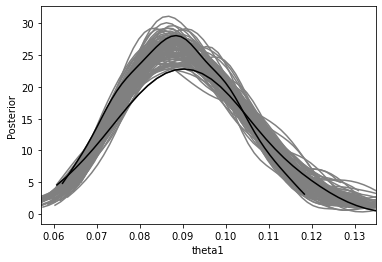

In [10]:
tmax=histories[0].max_t
fig,ax = plt.subplots()
highest=0
highest_index=0
lowest=1
lowest_index=0
for i in range(iters):
    df,w = histories[i].get_distribution(m=0,t=histories[i].max_t)
    pyabc.visualization.plot_kde_1d(df, w, x='theta1',ax=ax, color='grey')
    
    if w.max() >= highest:
        highest = w.max()
        highest_index = i
    if w.max() <= lowest:
        lowest = w.max()
        lowest_index = i

df_h, w_h = histories[highest_index].get_distribution(m=0,t=histories[highest_index].max_t)
pyabc.visualization.plot_kde_1d(df_h, w_h, x='theta1',ax=ax, color='black')

df_l, w_l = histories[lowest_index].get_distribution(m=0,t=histories[lowest_index].max_t)
pyabc.visualization.plot_kde_1d(df_l, w_l, x='theta1',ax=ax, color='black')

In [11]:
theta1_means = np.zeros(iters)
theta1_stds = np.zeros(iters)

theta2_means = np.zeros(iters)
theta2_stds = np.zeros(iters)

effective_sample_size=np.zeros(iters)

for i in range(iters):
    
    df,w= histories[i].get_distribution(m=0,t=histories[i].max_t)
    
    points = df['theta1'].values
    theta1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    theta1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    points = df['theta2'].values
    theta2_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    theta2_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    effective_sample_size[i]=pyabc.weighted_statistics.effective_sample_size(w)

allnames=[]
allnames.append("theta1_means")
allnames.append("theta2_means")
allnames.append("theta1_stds")
allnames.append("theta2_stds")
allnames.append("effective_sample_size")

alldata = []
for i in range(len(allnames)):
    alldata.append(eval(allnames[i]))

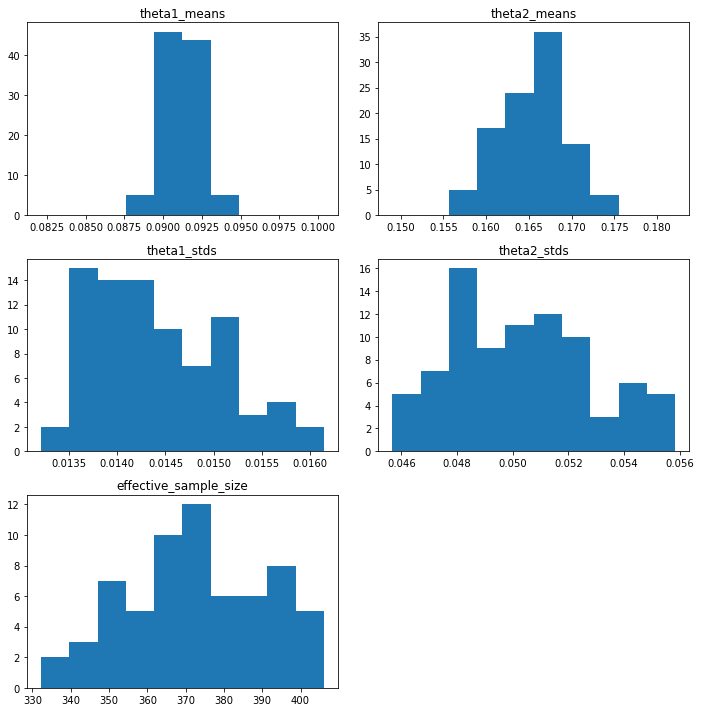

In [12]:
fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata[i], bins = 10, range=(0.9*alldata[i].mean(), 1.1*alldata[i].mean()))
    ax.set_title(allnames[i])
    
fig.tight_layout()


In [13]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = False)
abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        transitions=pyabc.LocalTransition(k_fraction=.3),
        eps=eps)

histories_ori=[]
runtimes_ori=np.zeros(iters)
for i in range(iters):
    starttime=time.time()
    abc.new(db_path, {"X_2": measurement_data});
    endtime=time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    histories_ori.append(h)
    runtimes[i]=endtime-starttime

INFO:History:Start <ABCSMC(id=1, start_time=2020-12-08 23:58:29.984002, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8578858734942583.
INFO:ABC:Acceptance rate: 500 / 1347 = 3.7120e-01, ESS=4.7315e+02.
INFO:ABC:t: 2, eps: 0.8182146239171071.
INFO:ABC:Acceptance rate: 500 / 1438 = 3.4771e-01, ESS=4.6941e+02.
INFO:ABC:t: 3, eps: 0.5024643698839607.
INFO:ABC:Acceptance rate: 500 / 3218 = 1.5538e-01, ESS=4.8178e+02.
INFO:ABC:t: 4, eps: 0.33586892457180945.
INFO:ABC:Acceptance rate: 500 / 2806 = 1.7819e-01, ESS=4.6277e+02.
INFO:ABC:t: 5, eps: 0.22923256437130785.
INFO:ABC:Acceptance rate: 500 / 5433 = 9.2030e-02, ESS=4.4318e+02.
INFO:ABC:t: 6, eps: 0.1653955476864991.
INFO:ABC:Acceptance rate: 500 / 24517 = 2.0394e-02, ESS=3.7637e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-08 23:58:29.984002, end_time=2020-12-08 23:58:48.139301)>
INFO:History:Start <ABCS

INFO:ABC:t: 3, eps: 0.5031728450597873.
INFO:ABC:Acceptance rate: 500 / 3083 = 1.6218e-01, ESS=4.6839e+02.
INFO:ABC:t: 4, eps: 0.335752497878478.
INFO:ABC:Acceptance rate: 500 / 3132 = 1.5964e-01, ESS=4.7989e+02.
INFO:ABC:t: 5, eps: 0.22882444243279756.
INFO:ABC:Acceptance rate: 500 / 5880 = 8.5034e-02, ESS=4.5694e+02.
INFO:ABC:t: 6, eps: 0.1633924913915639.
INFO:ABC:Acceptance rate: 500 / 27674 = 1.8068e-02, ESS=3.8199e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:00:57.835504, end_time=2020-12-09 00:01:17.055738)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:01:17.064743, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9671659272441653.
INFO:ABC:Acceptance rate: 500 / 1322 = 3.7821e-01, ESS=4.6312e+02.
INFO:ABC:t: 2, eps: 0.8392495433128112.
INFO:ABC:Acceptance rate: 500 / 1435 = 3.4843e-01, ESS=4.8032e+02.
INFO:ABC:t: 3, eps: 0.5048

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:03:36.189359, end_time=2020-12-09 00:03:54.212445)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:03:54.223683, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8291460911451396.
INFO:ABC:Acceptance rate: 500 / 1268 = 3.9432e-01, ESS=4.8089e+02.
INFO:ABC:t: 2, eps: 0.770659540947891.
INFO:ABC:Acceptance rate: 500 / 1427 = 3.5039e-01, ESS=4.7554e+02.
INFO:ABC:t: 3, eps: 0.49413164136223675.
INFO:ABC:Acceptance rate: 500 / 3216 = 1.5547e-01, ESS=4.7508e+02.
INFO:ABC:t: 4, eps: 0.3236548211351402.
INFO:ABC:Acceptance rate: 500 / 3319 = 1.5065e-01, ESS=4.8382e+02.
INFO:ABC:t: 5, eps: 0.21842945635537783.
INFO:ABC:Acceptance rate: 500 / 6740 = 7.4184e-02, ESS=4.4318e+02.
INFO:ABC:t: 6, eps: 0.15869766687259262.
INFO:ABC:Acceptance rate: 500 / 35226 = 1.4194e-02, ESS=3.4279e+02.
INFO:pyabc.util:Stopping

INFO:ABC:t: 2, eps: 0.7950195636891851.
INFO:ABC:Acceptance rate: 500 / 1598 = 3.1289e-01, ESS=4.9043e+02.
INFO:ABC:t: 3, eps: 0.49651816160007867.
INFO:ABC:Acceptance rate: 500 / 2892 = 1.7289e-01, ESS=4.2884e+02.
INFO:ABC:t: 4, eps: 0.3259225784972818.
INFO:ABC:Acceptance rate: 500 / 3067 = 1.6303e-01, ESS=4.8222e+02.
INFO:ABC:t: 5, eps: 0.22384942859178136.
INFO:ABC:Acceptance rate: 500 / 6097 = 8.2008e-02, ESS=4.2978e+02.
INFO:ABC:t: 6, eps: 0.1623353429577985.
INFO:ABC:Acceptance rate: 500 / 28355 = 1.7634e-02, ESS=3.8849e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:06:25.632611, end_time=2020-12-09 00:06:45.070389)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:06:45.079932, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9166998716242791.
INFO:ABC:Acceptance rate: 500 / 1271 = 3.9339e-01, ESS=4.8633e+02.
INFO:ABC:t: 2, eps: 0.80

INFO:ABC:t: 6, eps: 0.16672557901204524.
INFO:ABC:Acceptance rate: 500 / 21579 = 2.3171e-02, ESS=1.8274e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:08:55.921082, end_time=2020-12-09 00:09:12.914838)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:09:12.925734, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.81874696323635.
INFO:ABC:Acceptance rate: 500 / 1274 = 3.9246e-01, ESS=4.8112e+02.
INFO:ABC:t: 2, eps: 0.7774916481250471.
INFO:ABC:Acceptance rate: 500 / 1579 = 3.1666e-01, ESS=4.8412e+02.
INFO:ABC:t: 3, eps: 0.4910986936480762.
INFO:ABC:Acceptance rate: 500 / 2995 = 1.6694e-01, ESS=4.7834e+02.
INFO:ABC:t: 4, eps: 0.3273768359125488.
INFO:ABC:Acceptance rate: 500 / 3080 = 1.6234e-01, ESS=4.7488e+02.
INFO:ABC:t: 5, eps: 0.2285897826880354.
INFO:ABC:Acceptance rate: 500 / 5281 = 9.4679e-02, ESS=3.4603e+02.
INFO:ABC:t: 6, eps: 0.16758

INFO:ABC:t: 1, eps: 1.865505059601123.
INFO:ABC:Acceptance rate: 500 / 1237 = 4.0420e-01, ESS=4.7320e+02.
INFO:ABC:t: 2, eps: 0.8282491674181321.
INFO:ABC:Acceptance rate: 500 / 1353 = 3.6955e-01, ESS=4.7885e+02.
INFO:ABC:t: 3, eps: 0.5094386951666089.
INFO:ABC:Acceptance rate: 500 / 2987 = 1.6739e-01, ESS=4.1905e+02.
INFO:ABC:t: 4, eps: 0.3421064587350058.
INFO:ABC:Acceptance rate: 500 / 3031 = 1.6496e-01, ESS=4.7741e+02.
INFO:ABC:t: 5, eps: 0.23460476128298646.
INFO:ABC:Acceptance rate: 500 / 5290 = 9.4518e-02, ESS=4.5743e+02.
INFO:ABC:t: 6, eps: 0.17015235894081415.
INFO:ABC:Acceptance rate: 500 / 21803 = 2.2933e-02, ESS=3.7294e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:11:39.912338, end_time=2020-12-09 00:11:57.148171)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:11:57.158566, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 505 = 9.9010e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.870

INFO:ABC:t: 5, eps: 0.2088835158409924.
INFO:ABC:Acceptance rate: 500 / 7487 = 6.6782e-02, ESS=4.4426e+02.
INFO:ABC:t: 6, eps: 0.15025870146369077.
INFO:ABC:Acceptance rate: 500 / 50048 = 9.9904e-03, ESS=4.0639e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:14:06.628698, end_time=2020-12-09 00:14:32.851421)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:14:32.860776, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9506483461601265.
INFO:ABC:Acceptance rate: 500 / 1251 = 3.9968e-01, ESS=4.8246e+02.
INFO:ABC:t: 2, eps: 0.8248520656063175.
INFO:ABC:Acceptance rate: 500 / 1397 = 3.5791e-01, ESS=4.7462e+02.
INFO:ABC:t: 3, eps: 0.5085540962911976.
INFO:ABC:Acceptance rate: 500 / 3395 = 1.4728e-01, ESS=4.7347e+02.
INFO:ABC:t: 4, eps: 0.3453758479594483.
INFO:ABC:Acceptance rate: 500 / 3143 = 1.5908e-01, ESS=4.7386e+02.
INFO:ABC:t: 5, eps: 0.234

INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9624807598269312.
INFO:ABC:Acceptance rate: 500 / 1332 = 3.7538e-01, ESS=4.8279e+02.
INFO:ABC:t: 2, eps: 0.8353773066137985.
INFO:ABC:Acceptance rate: 500 / 1467 = 3.4083e-01, ESS=4.8366e+02.
INFO:ABC:t: 3, eps: 0.5206648962281702.
INFO:ABC:Acceptance rate: 500 / 2840 = 1.7606e-01, ESS=4.6405e+02.
INFO:ABC:t: 4, eps: 0.3418963985657352.
INFO:ABC:Acceptance rate: 500 / 3362 = 1.4872e-01, ESS=4.7893e+02.
INFO:ABC:t: 5, eps: 0.2340801282618904.
INFO:ABC:Acceptance rate: 500 / 5517 = 9.0629e-02, ESS=4.4730e+02.
INFO:ABC:t: 6, eps: 0.16790988005040905.
INFO:ABC:Acceptance rate: 500 / 24425 = 2.0471e-02, ESS=2.9240e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:17:02.785208, end_time=2020-12-09 00:17:21.332990)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:17:21.347950, end_time=None)>
INFO:ABC:t: 0, eps: 500.


INFO:ABC:t: 4, eps: 0.33676356155397325.
INFO:ABC:Acceptance rate: 500 / 3467 = 1.4422e-01, ESS=4.7254e+02.
INFO:ABC:t: 5, eps: 0.23100237754601294.
INFO:ABC:Acceptance rate: 500 / 5745 = 8.7032e-02, ESS=4.5145e+02.
INFO:ABC:t: 6, eps: 0.1652643968152015.
INFO:ABC:Acceptance rate: 500 / 24238 = 2.0629e-02, ESS=3.4996e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:19:43.269600, end_time=2020-12-09 00:20:01.448278)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:20:01.458564, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.9033677679559375.
INFO:ABC:Acceptance rate: 500 / 1362 = 3.6711e-01, ESS=4.7585e+02.
INFO:ABC:t: 2, eps: 0.7723704200086007.
INFO:ABC:Acceptance rate: 500 / 1550 = 3.2258e-01, ESS=4.8842e+02.
INFO:ABC:t: 3, eps: 0.49126740986420164.
INFO:ABC:Acceptance rate: 500 / 3394 = 1.4732e-01, ESS=4.6097e+02.
INFO:ABC:t: 4, eps: 0.3

INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:22:38.526396, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 506 = 9.8814e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8058239258075528.
INFO:ABC:Acceptance rate: 500 / 1329 = 3.7622e-01, ESS=4.7870e+02.
INFO:ABC:t: 2, eps: 0.8169759290918761.
INFO:ABC:Acceptance rate: 500 / 1433 = 3.4892e-01, ESS=4.8956e+02.
INFO:ABC:t: 3, eps: 0.5063773952806692.
INFO:ABC:Acceptance rate: 500 / 2949 = 1.6955e-01, ESS=4.1892e+02.
INFO:ABC:t: 4, eps: 0.33919057392514257.
INFO:ABC:Acceptance rate: 500 / 3083 = 1.6218e-01, ESS=4.7658e+02.
INFO:ABC:t: 5, eps: 0.23149866108245054.
INFO:ABC:Acceptance rate: 500 / 4972 = 1.0056e-01, ESS=4.5185e+02.
INFO:ABC:t: 6, eps: 0.1660409537884631.
INFO:ABC:Acceptance rate: 500 / 22458 = 2.2264e-02, ESS=3.6552e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:22:38.526396, end_time=2020-12-09 00:22:56.179571)>
INFO:History:Start <ABCS

INFO:ABC:t: 3, eps: 0.4931715314848093.
INFO:ABC:Acceptance rate: 500 / 2990 = 1.6722e-01, ESS=4.6073e+02.
INFO:ABC:t: 4, eps: 0.3344162085342813.
INFO:ABC:Acceptance rate: 500 / 2882 = 1.7349e-01, ESS=4.8218e+02.
INFO:ABC:t: 5, eps: 0.2306398559307032.
INFO:ABC:Acceptance rate: 500 / 5685 = 8.7951e-02, ESS=4.3698e+02.
INFO:ABC:t: 6, eps: 0.1634717944481976.
INFO:ABC:Acceptance rate: 500 / 26899 = 1.8588e-02, ESS=3.6421e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:25:03.423904, end_time=2020-12-09 00:25:22.269464)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:25:22.278585, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.7953436184507217.
INFO:ABC:Acceptance rate: 500 / 1256 = 3.9809e-01, ESS=4.7607e+02.
INFO:ABC:t: 2, eps: 0.7958123350576584.
INFO:ABC:Acceptance rate: 500 / 1468 = 3.4060e-01, ESS=4.7884e+02.
INFO:ABC:t: 3, eps: 0.4955

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-12-09 00:27:35.595298, end_time=2020-12-09 00:27:55.702501)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-12-09 00:27:55.711625, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 500 / 507 = 9.8619e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.8273879375303395.
INFO:ABC:Acceptance rate: 500 / 1223 = 4.0883e-01, ESS=4.7269e+02.
INFO:ABC:t: 2, eps: 0.8185306611275301.
INFO:ABC:Acceptance rate: 500 / 1499 = 3.3356e-01, ESS=4.7215e+02.
INFO:ABC:t: 3, eps: 0.5047906109943653.
INFO:ABC:Acceptance rate: 500 / 3042 = 1.6437e-01, ESS=4.5865e+02.
INFO:ABC:t: 4, eps: 0.3350453640593986.
INFO:ABC:Acceptance rate: 500 / 3115 = 1.6051e-01, ESS=4.7247e+02.
INFO:ABC:t: 5, eps: 0.22903131563887819.
INFO:ABC:Acceptance rate: 500 / 5415 = 9.2336e-02, ESS=4.4892e+02.
INFO:ABC:t: 6, eps: 0.16487877459299316.
INFO:ABC:Acceptance rate: 500 / 27191 = 1.8388e-02, ESS=3.6839e+02.
INFO:pyabc.util:Stopping

<AxesSubplot:xlabel='theta1', ylabel='Posterior'>

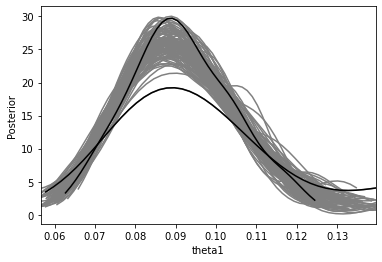

In [14]:
tmax=histories_ori[0].max_t
fig,ax = plt.subplots()
highest=0
highest_index=0
lowest=1
lowest_index=0
for i in range(iters):
    df,w = histories_ori[i].get_distribution(m=0,t=histories_ori[i].max_t)
    pyabc.visualization.plot_kde_1d(df, w, x='theta1',ax=ax, color='grey')
    
    if w.max() >= highest:
        highest = w.max()
        highest_index = i
    if w.max() <= lowest:
        lowest = w.max()
        lowest_index = i

df_h, w_h = histories_ori[highest_index].get_distribution(m=0,t=histories_ori[highest_index].max_t)
pyabc.visualization.plot_kde_1d(df_h, w_h, x='theta1',ax=ax, color='black')

df_l, w_l = histories_ori[lowest_index].get_distribution(m=0,t=histories_ori[lowest_index].max_t)
pyabc.visualization.plot_kde_1d(df_l, w_l, x='theta1',ax=ax, color='black')

In [15]:
o_theta1_means = np.zeros(iters)
o_theta1_stds = np.zeros(iters)

o_theta2_means = np.zeros(iters)
o_theta2_stds = np.zeros(iters)

o_effective_sample_size = np.zeros(iters)

for i in range(iters):
    
    df,w= histories_ori[i].get_distribution(m=0,t=histories_ori[i].max_t)
    
    points = df['theta1'].values
    o_theta1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    o_theta1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    points = df['theta2'].values
    o_theta2_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    o_theta2_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    o_effective_sample_size[i]=pyabc.weighted_statistics.effective_sample_size(w)

allnames_ori=[]
allnames_ori.append("o_theta1_means")
allnames_ori.append("o_theta2_means")
allnames_ori.append("o_theta1_stds")
allnames_ori.append("o_theta2_stds")
allnames_ori.append("o_effective_sample_size")

alldata_ori = []
for i in range(len(allnames_ori)):
    alldata_ori.append(eval(allnames_ori[i]))

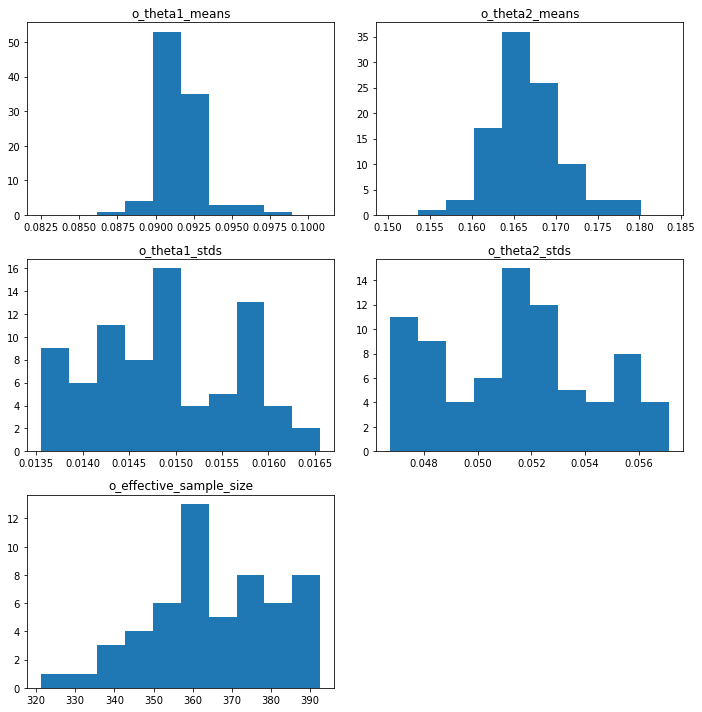

In [16]:
fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata_ori[i], bins = 10, range=(0.9*alldata_ori[i].mean(), 1.1*alldata_ori[i].mean()))
    ax.set_title(allnames_ori[i])
    
fig.tight_layout()

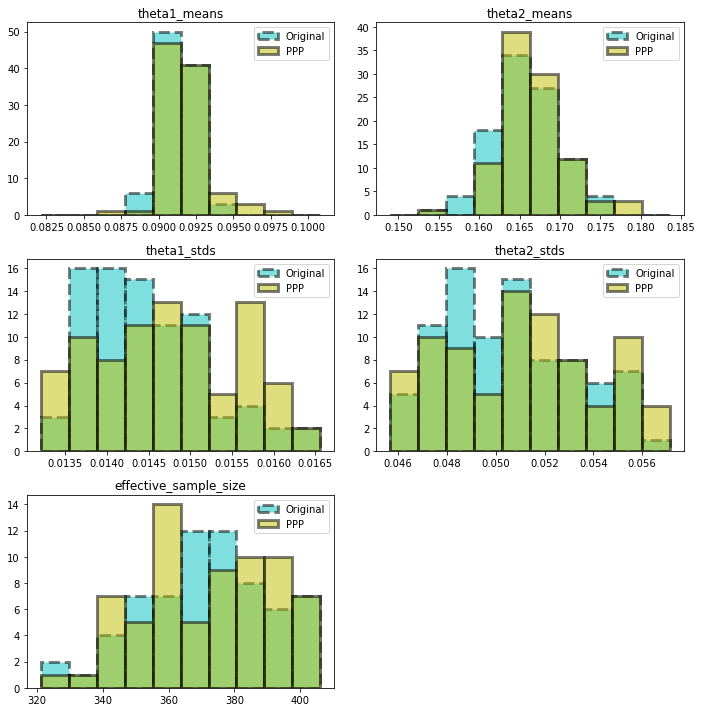

In [17]:
fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(allnames[i])

    lbound=0.9*min(alldata[i].mean(),alldata_ori[i].mean())
    ubound=1.1*max(alldata[i].mean(),alldata_ori[i].mean())

    # plot the histograms as usual
    bins = 10
    ax.hist(alldata[i], bins = bins, range = (lbound, ubound), color = 'c', edgecolor='black', ls='dashed', lw=3, label= "Original", alpha = 0.5)
    ax.hist(alldata_ori[i], bins = bins, range = (lbound, ubound), color = 'y', edgecolor='black', lw=3, label="PPP", alpha = 0.5)
    """
    countsboth=np.zeros(bins)
    vals=np.linspace(lbound, ubound, bins)
    bothdata=[]
    for j in range(bins):
        countsboth[j]=(min(counts1[j],counts2[j]))
        for k in range(int(countsboth[j])):
            bothdata.append(vals[j])
            
    counts3, edges3, bars3 = ax.hist(bothdata, range=(lbound, ubound), color = 'grey', label="both")
    
    minorder=0
    for b1 in bars1:
        if b1.get_zorder()>minorder:
            minorder = b1.get_zorder()
    for b2 in bars2:
        if b2.get_zorder()>minorder:
            minorder = b2.get_zorder()
    
    for b3 in bars3:
        b3.set_zorder(minorder+1)
    """
    ax.legend()
fig.tight_layout()


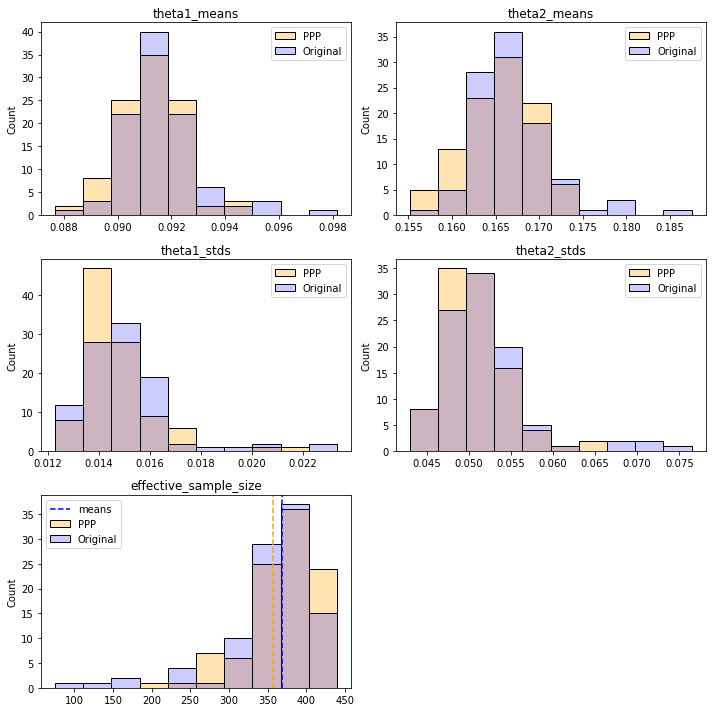

In [40]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
nx, ny=3, 2

for i in range(5):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(allnames[i])

    bins=10
    binrange_min=min(alldata[i].min(),alldata_ori[i].min())
    binrange_max=max(alldata[i].max(),alldata_ori[i].max())
    sns.histplot(alldata[i], ax = ax, bins = bins,
                 binrange = (binrange_min, binrange_max), common_bins = True,
                 kde=False, label="PPP", color = "orange", alpha = 0.3)
    sns.histplot(alldata_ori[i], ax = ax, bins = bins,
                 binrange = (binrange_min, binrange_max), common_bins = True,
                 kde=False, label="Original", color = "blue", alpha = 0.2)
    if allnames[i] == "effective_sample_size":
        ax.axvline(x = alldata[i].mean(), label="means", color="blue", linestyle="dashed")
        ax.axvline(x = alldata_ori[i].mean(),color="orange", linestyle="dashed")
        
    ax.legend()
fig.tight_layout()

fig.savefig("/home/felipe/MTGraphics/MeansIEcomparision.jpg")